<a href="https://colab.research.google.com/github/EnFiore/machine-learning-fondamenti/blob/main/4%20-%20Overfitting%20e%20Tecniche%20di%20Regolarizzazione/overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Riconoscere l'overfitting


In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
RANDOM_SEED = 0

In [5]:
from sklearn.model_selection import train_test_split
#crea dataset su cui creare il modello
X, y = make_regression(n_samples=100, n_features=100, n_informative=10, n_targets=1, bias=0.0, tail_strength=0.5, noise=50.0, random_state=RANDOM_SEED)
print(X.shape, y.shape)

(100, 100) (100,)


### Hold-out

In [6]:
#divido il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(75, 100) (75,)
(25, 100) (25,)


In [7]:
ss = StandardScaler()
#la standardizazione deve essere effettuata solo sui dati train
#i dati di test sono trasformati utilizzando la trasformazione del set train
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:
lr = LinearRegression()
#si crea il modello sul set di train
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
#funzione di addestrmaneto
def evaluate_model(model, dataset):

  X, y = dataset

  y_pred = model.predict(X)

  print(f"MSE: {mean_squared_error(y, y_pred):.3f}")
  print(f"R2: {r2_score(y, y_pred):.3f}")

In [12]:
#valuto modello su set di addestramento
evaluate_model(lr, (X_train, y_train))
##R2 indica modello perfetto. Sicuro overfitting

MSE: 0.000
R2: 1.000


In [11]:
#valutazione del modello sul set di test
evaluate_model(lr, (X_test, y_test))

MSE: 18043.679
R2: -0.150


### Cross-validation

In [14]:
from sklearn.model_selection import  cross_validate, cross_val_score, KFold

In [15]:
lr = LinearRegression()
#LA STANDARDIZAZZIONE deve essere eseguita sui dati che si passano alla fuznione di cros validatio, Per le funzioni
#usate non c'è modo
#alla funzione di passa la regressione, i dati, il numero di batch -cv, e la funzione di scoring)
scores = cross_val_score(lr, X, y, cv=5, scoring="r2")
#restituisce il valore di R2 del test per ciascun modello
scores

array([ 0.29454432,  0.31368347,  0.10498614,  0.05530266, -0.26826511])

In [16]:
#media dei valori
scores.mean()

np.float64(0.10005029402140228)

In [18]:
lr = LinearRegression()
#altra funzione per fare cross-validation
#si passa modello, dati, numero di batch -cv, ottenre il risultato per l'eddestramento e non solo per il test
cv_results = cross_validate(lr, X, y, cv=5, return_train_score=True)
cv_results
#restituice il tempo per addestrare, per fare lo score, il risultato del test score e del train score

{'fit_time': array([0.00480247, 0.00243855, 0.00233293, 0.00228119, 0.00222325]),
 'score_time': array([0.00120854, 0.00084686, 0.0007813 , 0.00085402, 0.00071383]),
 'test_score': array([ 0.29454432,  0.31368347,  0.10498614,  0.05530266, -0.26826511]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [19]:
cv_results["train_score"].mean()

np.float64(1.0)

In [20]:
cv_results["test_score"].mean()

np.float64(0.10005029402140228)

In [26]:
# DATI STANDARDIZZATI occorre costruire la funzione di cross validation
# kfold permette di fare la divisione in batch del set di dati.
# shuffle mescola id ati
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
#di mpasa il dataset che verrà diviso
kf.get_n_splits(X)

5

In [27]:
#cilco per addestrare i modelli sui vari batch
train_score = []
test_score = []

for train_index, test_index in kf.split(X):
  #split restituisce l'indice del batch da utilizzare per il training e per il test
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
#si sesegue la standardizzazione. Ricorda che va fatta su Xtrain con fit.transform
# e applicata poi sul x test, solo transform
  ss = StandardScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)
#si crea il modello e lo si valuta
  lr = LinearRegression()
  lr.fit(X_train, y_train)

  r2_train = r2_score(y_train, lr.predict(X_train))
  train_score.append(r2_train)

  r2_test = r2_score(y_test, lr.predict(X_test))
  test_score.append(r2_test)
#usciti dal ciclo si crea dizionario con test score e train score
scores = {
      "train_score":np.array(train_score),
      "test_score":np.array(test_score)
    }

In [28]:
scores
#train score ha valore 1 = overfitting

{'train_score': array([1., 1., 1., 1., 1.]),
 'test_score': array([ 0.21957391, -0.23936058,  0.38698363,  0.30646853,  0.4420139 ])}

In [29]:
scores["train_score"].mean()

np.float64(1.0)

In [30]:
scores["test_score"].mean()

np.float64(0.2231358745203887)

### LOOCV

variante di cross validation. Si esegue addestramento su tutti i valori del dataset, meno uno. che sarà usato come test

non è altro che una kfold dove il numero di batch è uguale al numero dei dati

**si usa per dataset molto piccoli**

In [31]:
from sklearn.model_selection import LeaveOneOut

In [33]:
loo = LeaveOneOut()
loo.get_n_splits(X)

100

In [37]:
train_score = []
test_score = []
#ciclo per STANDARDIZZARE I DATI
for train_index, test_index in loo.split(X):

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = StandardScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LinearRegression()
  lr.fit(X_train, y_train)

#si usa il MSE come metrica perchè R2 non puù essere valutato per un solo dato di test
  mse_train = mean_squared_error(y_train, lr.predict(X_train))
  train_score.append(mse_train)

  r2_test = mean_squared_error(y_test, lr.predict(X_test))
  test_score.append(r2_test)

costs = {
      "train_cost":np.array(train_score),
      "test_cost":np.array(test_score)
    }

In [38]:
costs
#SME non è un fuzione di score ma di costo

{'train_cost': array([1.51723801e-25, 9.33615128e-26, 1.53370815e-25, 1.20611796e-25,
        8.45359283e-26, 1.65065304e-25, 8.51500923e-26, 1.58230900e-25,
        9.17732091e-26, 1.07711036e-25, 8.91775858e-26, 1.07115677e-25,
        1.24592883e-25, 9.57666621e-26, 1.18243174e-25, 9.39702903e-26,
        1.47915627e-25, 1.13269366e-25, 1.17087517e-25, 1.87076276e-25,
        1.06316808e-25, 9.88807981e-26, 1.41164890e-25, 1.33252408e-25,
        1.03805075e-25, 8.66909369e-26, 9.48842534e-26, 1.16205235e-25,
        1.48104061e-25, 8.55724756e-26, 9.81436354e-26, 9.62381300e-26,
        1.29066218e-25, 9.73500892e-26, 1.24286008e-25, 1.36606485e-25,
        1.21709891e-25, 1.43843001e-25, 1.51804918e-25, 1.47140599e-25,
        1.72713462e-25, 1.08821529e-25, 1.29401141e-25, 1.24642605e-25,
        1.15800606e-25, 1.30440079e-25, 8.25565089e-26, 1.24622971e-25,
        9.41170344e-26, 7.92636282e-26, 9.77381769e-26, 1.24338152e-25,
        8.61025582e-26, 1.25644538e-25, 1.31223904

In [39]:
scores["train_score"].mean()
#valore prossimo allo zero

np.float64(1.1518666709145146e-25)

In [40]:
scores["test_score"].mean()
#valore molto alto
#si tratta di overfitting

np.float64(6764.252122395523)

### Learning Curve


In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

train_sizes_abs, train_scores, test_scores = learning_curve(LinearRegression(), X, y, random_state=RANDOM_SEED)

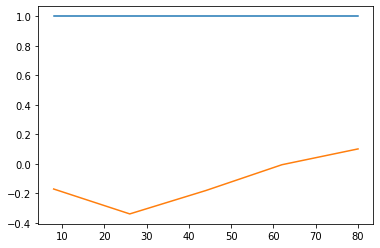

In [ ]:
plt.plot(train_sizes_abs, train_scores.mean(axis=1))
plt.plot(train_sizes_abs, test_scores.mean(axis=1))
plt.show()